# VAR -  Vector Autoregression Model
http://machinelearningplus.com/time-series/vector-autoregression-examples-python/ <br>
- <b> Autoregressive model </b> --> each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.
- <b> Bidirectional model </b> --> predictors influence Y AND Y influence predictors = variables influence each other

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from itertools import permutations
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.var_model import VAR
from typing import Union
from tqdm import tqdm
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

df = pd.read_excel('./italy_values_dataset.xlsx')

# plot styles
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

CATEGORIES = {
    'demography': ['population', 'growth', 'employment', 'Employment'],
    'land_use': ['area', 'land', 'cropland'],
    'prerequisites': ['withdrawals', 'fertilizer'],
    'production': ['production', 'yield'],
    'economy': ['value', 'added', 'value added', 'exports', 'imports']        
}

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

Each variable is modeled as a linear combination of past values of itself and the past values of other variables in the system. Since you have multiple time series that influence each other, it is modeled as a system of equations with one equation per variable (time series).

1. Analyze the time series characteristics
2. Test for causation amongst the time series
3. Test for stationarity
4. Transform the series to make it stationary, if needed
5. Find optimal order (p)
6. Prepare training and test datasets
7. Train the model
8. Roll back the transformations, if any.
9. Evaluate the model using test set
10. Forecast to future

In [44]:
def prepare_wide_dataset(df):
    if 'Indicator Name' not in df.columns:
        raise ValueError("Il DataFrame deve contenere una colonna 'Indicator Name'")

    original_indicator_order = df['Indicator Name'].unique()
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df_long = df.melt(id_vars='Indicator Name', value_vars=year_cols,
                    var_name='Year', value_name='Value')

    df_wide = df_long.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()
    
    df_wide['Year'] = df_wide['Year'].astype(int)
    df_wide = df_wide.sort_values('Year').reset_index(drop=True)
    df_wide.columns.name = None
    
    # rimuovo variabili inutilizzabili
    unusable_cols = [col for col in df_wide.columns if col in UNUSABLE]
    if unusable_cols:
        df_wide = df_wide.drop(columns=unusable_cols)

    final_column_order = ['Year']
    for indicator in original_indicator_order:
        if indicator in df_wide.columns:
            final_column_order.append(indicator)
    df_wide = df_wide[final_column_order]
    return df_wide

In [45]:
def plot_timeseries(df):
    data_columns = df.columns
    n_vars = len(data_columns)

    ncols = 3
    nrows = int(np.ceil(n_vars / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10, nrows * 2.5))
    axes_flat = axes.flatten()

    print(f"Creazione griglia {nrows}x{ncols} per {n_vars} variabili")
    for i, col_name in enumerate(data_columns):
        ax = axes_flat[i]
        data = df[col_name]

        ax.plot(data.index, data.values, color='red', linewidth=1.0, marker='.', markersize=4)
        ax.set_title(col_name, fontsize=9)
        ax.tick_params(labelsize=7)
        ax.spines["top"].set_alpha(0)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        if i >= n_vars - ncols:
            ax.set_xlabel('Year', fontsize=8)

    for i in range(n_vars, len(axes_flat)):
        axes_flat[i].axis('off')
    plt.tight_layout()

Creazione griglia 9x3 per 27 variabili


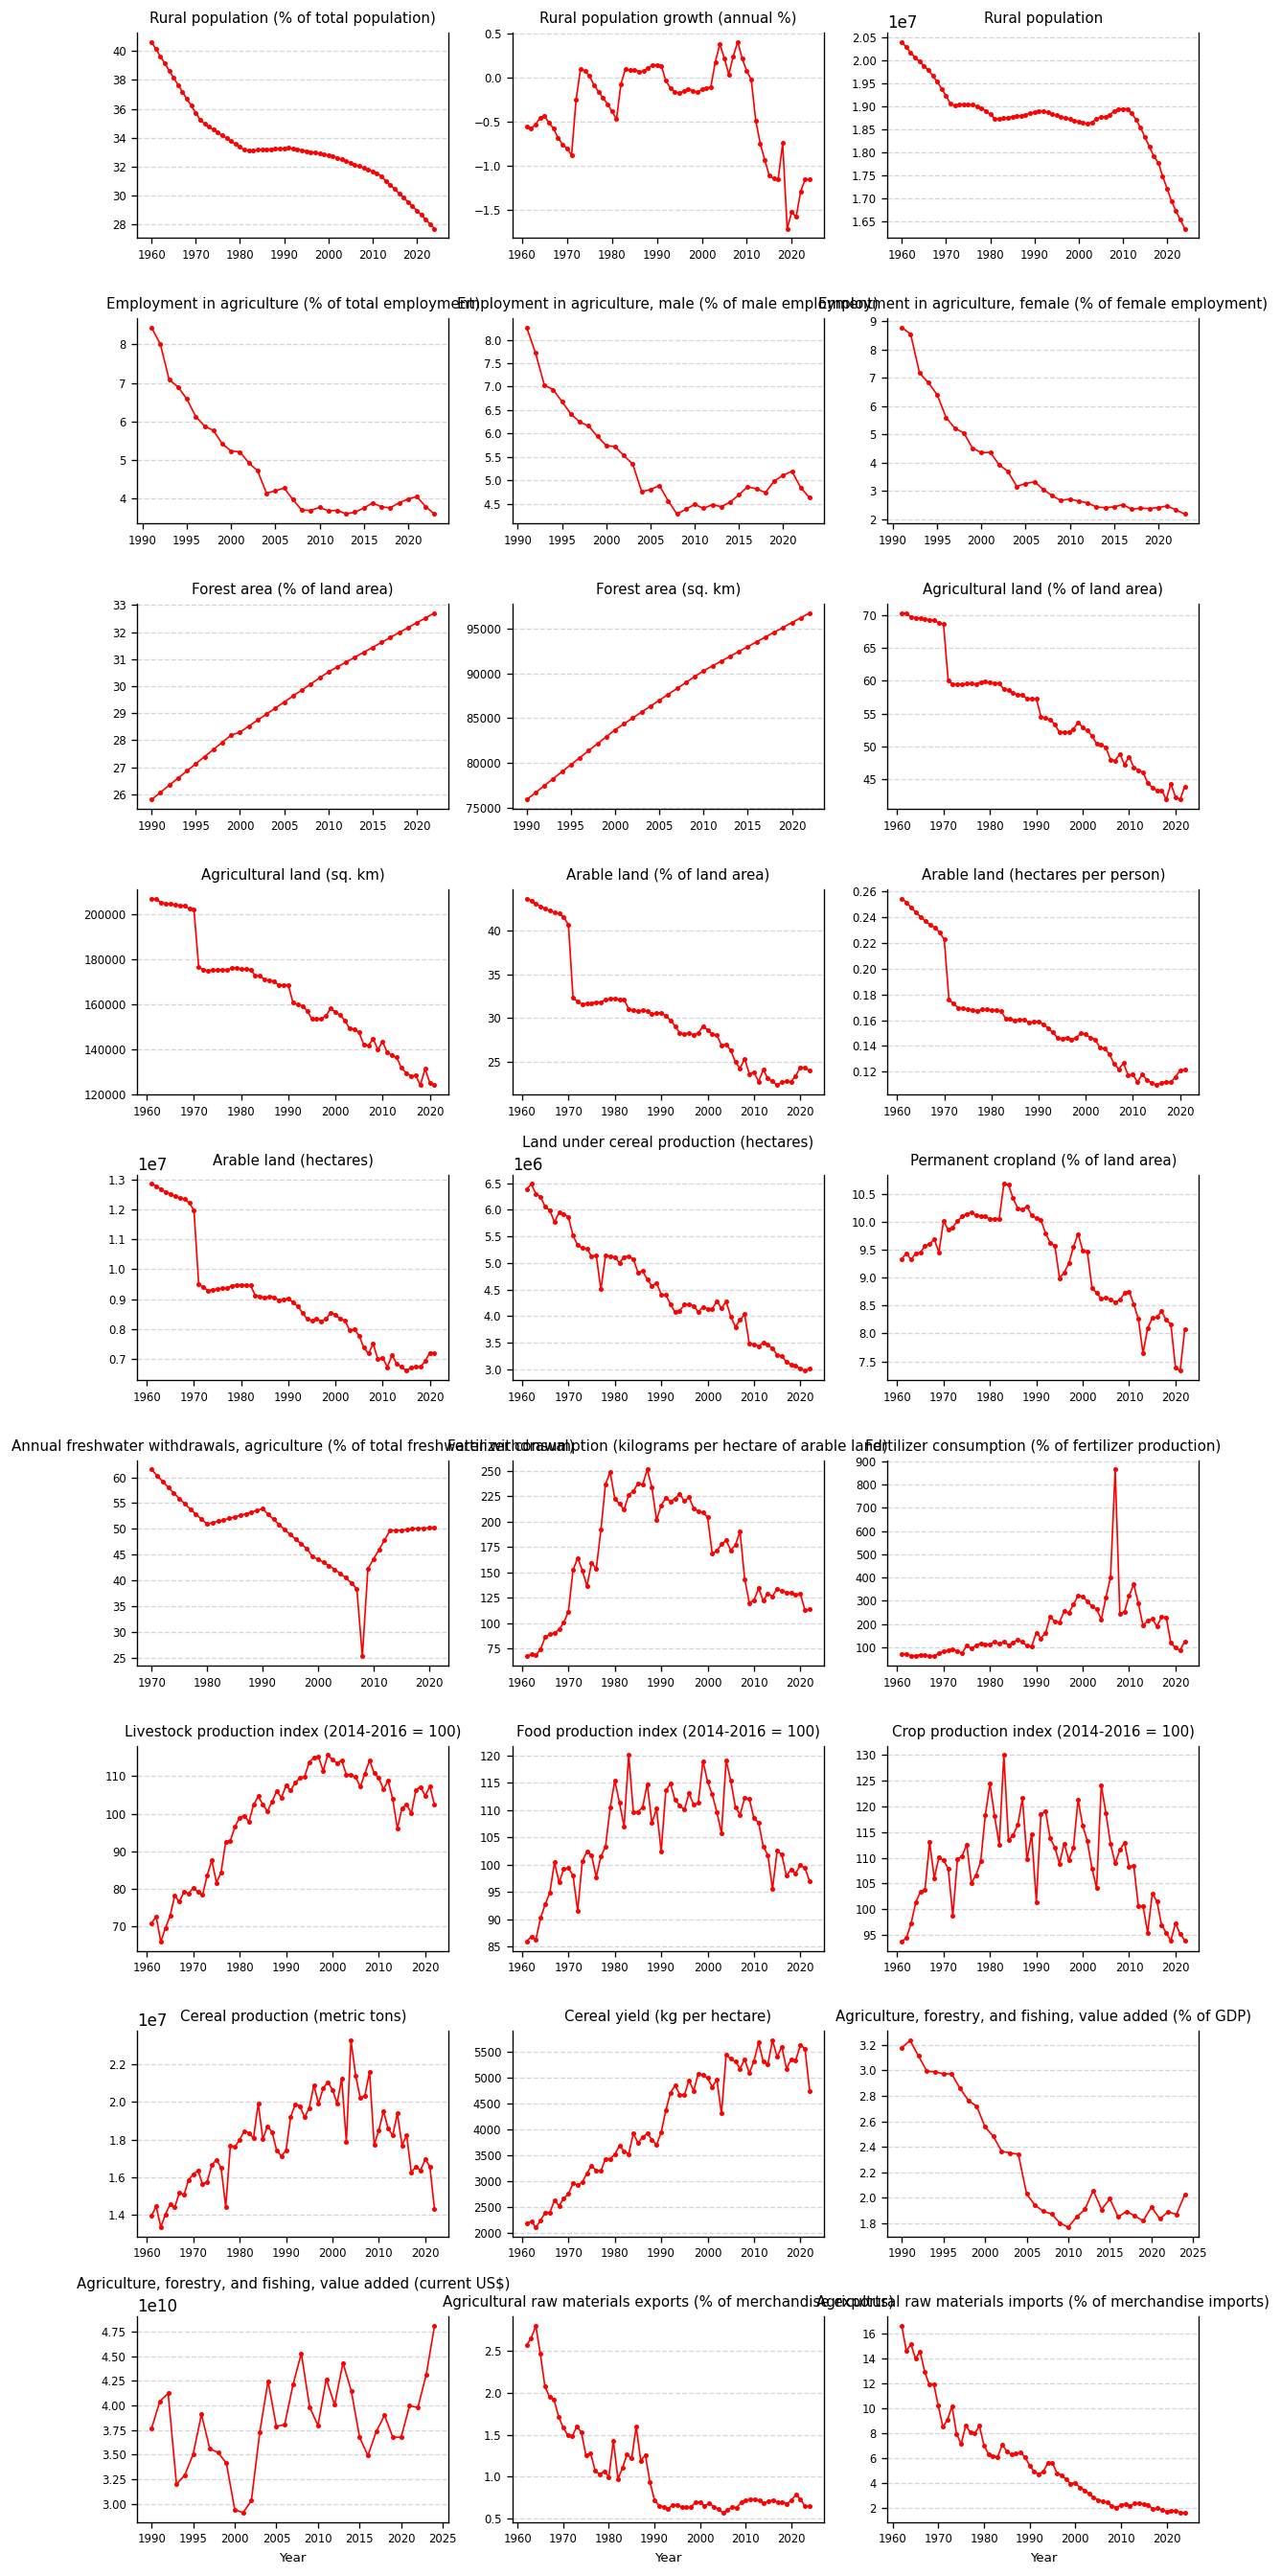

In [46]:
wide_df = prepare_wide_dataset(df)
wide_df.set_index('Year', inplace=True)
plot_timeseries(wide_df)

- stationary
- seasonality
- structural breaks
- [spurious correlation](https://statisticsbyjim.com/basics/spurious-correlation/): a spurious correlation occurs when two variables are correlated but don’t have a causal relationship. In other words, it appears like values of one variable cause changes in the other variable, but that’s not actually happening. 

In [47]:
def make_stationary(series):
    def is_stationary(series):
        result = adfuller(series.dropna())
        return result[1] < 0.05  # p-value < 0.05 → stazionaria
    
    if is_stationary(series) : 
        #print("Serie stazionaria")
        return series, 0
    
    current_series = series.copy()
    for d in range(1, 3):
        current_series = current_series.diff()
        if is_stationary(current_series):
            return current_series, d
    
    return current_series, 2

- test di stazionarietà = _ADF_ --> rendo tutte le time serie stazionarie + divido tra quelle stazionarie originariamente e quelle che hanno avuto di bisogno di 1 o 2 differenziazioni. 

**Questo ci porterà a 3 gruppi di time series:**
1. stazionarie <br>
2. 1-diff-transformed  -> non sono cointegrate = VAR standard sulle differenze <br>
-> sono cointegrate = VECM (Vector Error Correction Model) <br>
3. 2-diff-transformed <br>

- test di cointegrazione = _Johansen_ --> sulle 1-diff-transformed
    - prerequisiti: no multicollinearità e ritardi p appropriati
    - se r = 0 : nessuna cointegrazione --> VAR standard su tutte e tre i gruppi di prima
    - se r > 0 : sì cointegrazione --> VECM su variabili I(1) [si possono includere I(0), NON possono essere incluse I(2)]

In [48]:
df_metadata = []
stationary_series = {}
original_I1_series = {}
original_I2_series = {}

for col_name, series in wide_df.items():
    made_stat_serie, d = make_stationary(series)

    stationary_series[col_name] = made_stat_serie
    df_metadata.append({"Indicator": col_name, "d": d, "p": np.nan, "Best AIC": np.nan})

    if d == 1: original_I1_series[col_name] = series 
    elif d > 1: original_I2_series[col_name] = series

df_metadata = pd.DataFrame(df_metadata).set_index("Indicator")
df_stationary_series = pd.DataFrame(stationary_series)
df_I1_levels = pd.DataFrame(original_I1_series)
df_I2_levels = pd.DataFrame(original_I2_series)

# display(df_metadata.head())
# display(df_stationary_series.head())
# display(df_I1_levels.head())
# display(df_I2_levels.head())

if len(df_I1_levels.columns) < 2:
    print("Non ci sono abbastanza variabili I(1) per eseguire un test di cointegrazione.")
    rango_finale = 0

In [49]:
corr_matrix = df_stationary_series.dropna().corr().abs()  # Calcola la matrice di correlazione
# Crea una maschera per la parte superiore (per evitare duplicati)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

CORRELATED_COUPLES = [
    column for column in upper_triangle.columns 
    if any(upper_triangle[column] > 0.99)
]

if CORRELATED_COUPLES:
    print("ATTENZIONE: Trovata multicollinearità elevata (> 0.99)")
    print("Coppie problematiche:")

    for col in upper_triangle.columns:
        highly_corr = upper_triangle.index[upper_triangle[col] > 0.99].tolist()
        if highly_corr:
            print(f"- {col} = {highly_corr}")
else:
    print("Nessuna multicollinearità perfetta (>0.99) trovata.")

ATTENZIONE: Trovata multicollinearità elevata (> 0.99)
Coppie problematiche:
- Rural population = ['Rural population growth (annual %)']
- Employment in agriculture, female (% of female employment) = ['Employment in agriculture (% of total employment)']
- Agricultural land (sq. km) = ['Agricultural land (% of land area)']
- Arable land (hectares per person) = ['Arable land (% of land area)']
- Arable land (hectares) = ['Arable land (% of land area)', 'Arable land (hectares per person)']


In [50]:
REDUNDANT = [
    'Agricultural land (sq. km)', 
    'Arable land (hectares)', 
    'Arable land (hectares per person)',
    'Rural population',
    'Employment in agriculture, female (% of female employment)',
    'Employment in agriculture, male (% of male employment)',
    'Rural population growth (annual %)',
    'Forest area (sq. km)'
]

CATEGORIES = {
    'production' : ['Cereal yield (kg per hectare)',
                    'Livestock production index (2014-2016 = 100)',
                    'Food production index (2014-2016 = 100)',
                    'Crop production index (2014-2016 = 100)',
                    'Cereal production (metric tons)',
                    'Agriculture, forestry, and fishing, value added (current US$)'],
    'land_use' : ['Permanent cropland (% of land area)', 
                    'Land under cereal production (hectares)',
                    'Arable land (% of land area)',
                    'Agricultural land (% of land area)'],
    'prerequisites' : ['Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)',
                    'Fertilizer consumption (% of fertilizer production)']
}

df_I1_johansen = df_I1_levels.drop(columns=REDUNDANT, errors='ignore')
cointegration_results = {}

for category_name, var_list in CATEGORIES.items():
    print(f"\n=======================================================")
    print(f"CATEGORIA: {category_name.upper()}")
    print(f"=======================================================")
    
    # Seleziona le vars I(1) pulite per questo gruppo
    # (intersezione tra le vars I(1) e quelle della categoria)
    vars_to_test = [col for col in var_list if col in df_I1_johansen.columns]
    
    if len(vars_to_test) < 2:
        print(f"Test saltato: meno di 2 vars I(1) in questo gruppo ({vars_to_test}).")
        cointegration_results[category_name] = {'rank': 0, 'status': 'Saltato - Poche vars I(1)', 'vars': vars_to_test}
        continue
        
    print(f"vars I(1) in test: {vars_to_test}")
    subgroup_df = df_I1_johansen[vars_to_test].dropna()
    
    # Controlla se abbiamo abbastanza dati dopo il dropna (richiede più righe che colonne * ritardi)
    if subgroup_df.shape[0] < 20:
        print(f"Test saltato: dati insufficienti dopo dropna ({subgroup_df.shape[0]} righe).")
        cointegration_results[category_name] = {'rank': 0, 'status': 'Saltato - Dati insuff.', 'vars': vars_to_test}
        continue

    # Selezione Ritardo (sul sottogruppo)
    try:
        var_model_sub = VAR(subgroup_df)
        
        # Calcola maxlags sicuro per evitare 'maxlags is too large'
        safe_maxlags = min(4, subgroup_df.shape[0] - 1) # Limite arbitrario di 4, o meno se i dati sono pochi
        safe_maxlags = max(1, safe_maxlags) # Assicurati sia almeno 1
        
        selected_result = var_model_sub.select_order(maxlags=safe_maxlags)
        p_lags = selected_result.selected_orders['aic']
        if p_lags == 0:
            p_lags = 1 # Forza almeno un ritardo p=1 se AIC sceglie 0
        k_ar_diff = p_lags - 1
        print(f"Ritardo ottimale (p): {p_lags} | k_ar_diff (p-1): {k_ar_diff}")
    except Exception as e:
        print(f"Errore selezione ritardi, uso k_ar_diff=1 (p=2). Errore: {e}")
        k_ar_diff = 1 # Fallback
        
    try:
        johansen_result = coint_johansen(
            subgroup_df,
            det_order=1,
            k_ar_diff=k_ar_diff
        )

        trace_rank = 0
        significance_level = 1 # 5%
        
        print("H0: r <= k  | Stat. Traccia | Val. Critico (5%) | Decisione")
        
        for i in range(len(subgroup_df.columns)):
            stat = johansen_result.lr1[i]
            crit = johansen_result.cvt[i, significance_level]

            if np.isnan(crit):
                print(f"H0: r <= {i:<2} | {stat:<13.2f} | {crit:<17.2f} | ERRORE (nan)")
                break
            
            decision = "Rifiuta H0"
            if stat > crit:
                trace_rank = i + 1
            else:
                decision = "Non Rifiuta H0"
            
            print(f"H0: r <= {i:<2} | {stat:<13.2f} | {crit:<17.2f} | {decision}")
            
            if decision == "Non Rifiuta H0":
                break
                
        final_rank = trace_rank
        print(f"\n--> rank di Cointegrazione (r) per '{category_name}': {final_rank}")
        
        if final_rank > 0:
            print("--> CONCLUSIONE: Le serie in questo gruppo sono COINTEGRATE (usare VECM).")
            cointegration_results[category_name] = {'rank': final_rank, 'status': 'Cointegrato', 'vars': vars_to_test}
        else:
            print("--> CONCLUSIONE: Le serie non sono cointegrate (usare VAR in differenze).")
            cointegration_results[category_name] = {'rank': 0, 'status': 'Non Cointegrato', 'vars': vars_to_test}

    except np.linalg.LinAlgError:
        print("ERRORE: LinAlgError (Matrice non definita positiva).")
        print("--> Causa probabile: multicollinearità residua o dati insufficienti.")
        print("--> CONCLUSIONE: Tratto come Non Cointegrato (r=0).")
        cointegration_results[category_name] = {'rank': 0, 'status': 'Errore (LinAlg)', 'vars': vars_to_test}

print("\n=======================================================")
print("RIEPILOGO TEST DI COINTEGRAZIONE")
print("=======================================================")
print(f"{'Categoria':<15} | {'rank (r)':<8} | {'Status':<20} | vars Testate")
print("-" * 80)

for cat, res in cointegration_results.items():
    vars_str = ', '.join(res['vars']) if res['vars'] else 'N/A'
    print(f"{cat:<15} | {res['rank']:<8} | {res['status']:<20} | {vars_str}")


CATEGORIA: PRODUCTION
vars I(1) in test: ['Cereal yield (kg per hectare)', 'Livestock production index (2014-2016 = 100)', 'Food production index (2014-2016 = 100)', 'Crop production index (2014-2016 = 100)', 'Cereal production (metric tons)', 'Agriculture, forestry, and fishing, value added (current US$)']
Errore selezione ritardi, uso k_ar_diff=1 (p=2). Errore: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
H0: r <= k  | Stat. Traccia | Val. Critico (5%) | Decisione
H0: r <= 0  | 120.92        | 107.34            | Rifiuta H0
H0: r <= 1  | 77.40         | 79.34             | Non Rifiuta H0

--> rank di Cointegrazione (r) per 'production': 1
--> CONCLUSIONE: Le serie in questo gruppo sono COINTEGRATE (usare VECM).

CATEGORIA: LAND_USE
vars I(1) in test: ['Permanent cropland (% of land area)', 'Land under cereal production (hectares)', 'Arable land (% of land area)', 'Agricultural land (% of land area)']
Ritardo 

- r = 0 --> non hanno una relazione di equilibrio stabile nel lungo periodo. Anche se vagano (essendo I(1)), non sono "legate" l'una all'altra. Posso usare VAR.
- r > 0 --> hanno una relazione di equilibrio stabile nel lungo periodo. 
    - Questo gruppo di 5 variabili è "legato" da 3 relazioni di lungo periodo (guinzagli). Anche se le singole serie vagano, queste 3 relazioni le costringono a muoversi insieme nel tempo. Queste variabili devono essere modellate usando un VECM (Vector Error Correction Model), che modella sia le dinamiche di breve periodo (le differenze) sia il ritorno all'equilibrio di lungo periodo (l'Error Correction Term).

In [51]:
# escludiamo vars cointegrate che non possono essere studiate da VAR ma necessitano di VECM
excluded_from_var = []
for cat, res in cointegration_results.items():
    if res['rank'] > 0:
        excluded_from_var.extend(res['vars'])

# escludiamo anche redundant che non mi interessano
for item in REDUNDANT:
    if item not in excluded_from_var:
        excluded_from_var.append(item)
# print(f"vars cointegrate (r > 0) o ridondanti da escludere dal VAR: {excluded_from_var}")

# prendo tutte le serie rese stazionarie 
# + tolgo le vars cointegrate e quelle ridondanti 
# + tolgo nan che non possono esserci per VAR
df_var_input = df_stationary_series.copy()
df_var_input = df_var_input.drop(columns=excluded_from_var, errors='ignore')
df_var_input = df_var_input.dropna()

print(df_var_input.shape)
display(df_var_input.head())

(31, 11)


,Rural population (% of total population),Employment in agriculture (% of total employment),Forest area (% of land area),Agricultural land (% of land area),Arable land (% of land area),Land under cereal production (hectares),Permanent cropland (% of land area),Fertilizer consumption (kilograms per hectare of arable land),"Agriculture, forestry, and fishing, value added (% of GDP)",Agricultural raw materials exports (% of merchandise exports),Agricultural raw materials imports (% of merchandise imports)
Year,,,,,,,,,,,
1992,-0.036,8.004366,26.335895,-0.258407,-0.510013,-176287.0,-0.241406,-11.035499,-0.177889,0.640307,4.709148
1993,-0.060,7.082705,26.600932,-0.231206,-0.680018,-149640.0,-0.166604,6.587672,0.001933,0.621360,4.925032
1994,-0.060,6.897878,26.865969,-0.707218,-0.751420,27970.0,-0.054401,1.482552,0.112244,0.660861,5.606190
1995,-0.060,6.583007,27.131005,-1.254633,-0.156404,112500.0,-0.574615,-11.717296,-0.006918,0.667001,5.644685
1996,-0.060,6.128945,27.396042,0.054401,0.166604,7398.0,0.098603,11.080728,0.011989,0.635116,4.774820


In [72]:
max_lag_granger = 3

def test_granger_pair(data, causing_var, caused_var, maxlag):
    """
    Esegue il test di Granger per una singola coppia e restituisce il p-value minimo.
    H0: 'causing_var' NON causa (Granger) 'caused_var'
    """
    test_data = data[[caused_var, causing_var]]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            results = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)
        except Exception as e:
            print(f"Errore testando {causing_var} -> {caused_var}: {e}")
            return np.nan

    # Estraiamo il p-value minimo tra tutti i ritardi testati
    # Ci interessa il test 'ssr_ftest' (colonna 1)
    min_p_value = 1.0
    for lag in range(1, maxlag + 1):
        p_value = results[lag][0]['ssr_ftest'][1]
        if p_value < min_p_value:
            min_p_value = p_value
    return min_p_value

variables = df_var_input.columns
granger_results = []

# 'permutations' testa sia (A, B) che (B, A)
for pair in permutations(variables, 2):
    causing_var = pair[0]
    caused_var = pair[1]
    
    p_value = test_granger_pair(df_var_input, causing_var, caused_var, max_lag_granger)
    
    granger_results.append({
        "Variabile Causa (X)": causing_var,
        "Variabile Effetto (Y)": caused_var,
        "Min P-Value": p_value
    })

df_granger_summary = pd.DataFrame(granger_results)
df_granger_summary = df_granger_summary.sort_values(by="Min P-Value")
display(df_granger_summary.head(10))

,Variabile Causa (X),Variabile Effetto (Y),Min P-Value
19,Employment in agriculture (% of total employment),Agricultural raw materials imports (% of merch...,0.002420
14,Employment in agriculture (% of total employment),Land under cereal production (hectares),0.003566
50,Land under cereal production (hectares),Rural population (% of total population),0.014914
56,Land under cereal production (hectares),Fertilizer consumption (kilograms per hectare ...,0.019967
75,Fertilizer consumption (kilograms per hectare ...,Land under cereal production (hectares),0.023303
44,Arable land (% of land area),Land under cereal production (hectares),0.026710
34,Agricultural land (% of land area),Land under cereal production (hectares),0.026898
90,Agricultural raw materials exports (% of merch...,Rural population (% of total population),0.032297
20,Forest area (% of land area),Rural population (% of total population),0.034874
85,"Agriculture, forestry, and fishing, value adde...",Land under cereal production (hectares),0.047379


*Domande che mi devo fare per coppie:*
1. Do they make sense as causal relationships? <br> 
2. Do they fit established theory? <br>
3. Can you find a mechanism for causation? <br>
4. Is there a direct link, or are mediator variables involved? <br>

*Scrematura logica dei risultati della Granger causality:*
- **Employment in agriculture - Agricultural raw materials imports** = meno persone lavorano nell'agricoltura più bisogna importare?
- **Employment in agriculture - Land under cereal production** = meno persone lavorano nell'agricoltura più diminuisce la superficie dei campi di cereali
- **Land under cereal production - Fertilizer consumption** = più aumenta la terra arata a cereali più aumenta il consumo di fertilizzanti (questo ci sta!!)
- Arable land - Land under cereal production = meno terra arabile, meno terra arata a cereali (boh sembra stupido)

In [74]:
def optimize_VARMAX(endog: pd.DataFrame, max_p_to_try: int) -> int:
    results = []
    for i in tqdm(range(1, max_p_to_try + 1), desc="Ottimizzazione AIC"):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(disp=False)
            results.append({'p': i, 'aic': model.aic})
        except Exception:
            break
            
    if not results:
        return 1 # Fallback

    result_df = pd.DataFrame(results)
    best_p = result_df.loc[result_df['aic'].idxmin()]['p']
    return int(best_p)

Per ogni coppia che ho individuato:
1. trovo la p ottimale
2. stimo modello VARMAX(p,0)
3. faccio residual analysis
    - QQ plot: i residui sono "normali"? --> i punti devono seguire la linea rossa
    - ACF plot: i residui sono "non correlati"? --> le barre devono stare nell'area blu
    - Ljung-box test: versione numerica dell'ACF plot --> p-value deve essere > 0.05

ANALISI COPPIA: 'Employment in agriculture (% of total employment)' -> 'Agricultural raw materials imports (% of merchandise imports)'


Ottimizzazione AIC:  90%|█████████ | 9/10 [02:36<00:17, 17.37s/it]


Ritardo ottimale (AIC) scelto (p): 1
Ljung-Box p-value (Employment in agriculture (% of total employment)): 0.9911
Ljung-Box p-value (Agricultural raw materials imports (% of merchandise imports)): 0.7738


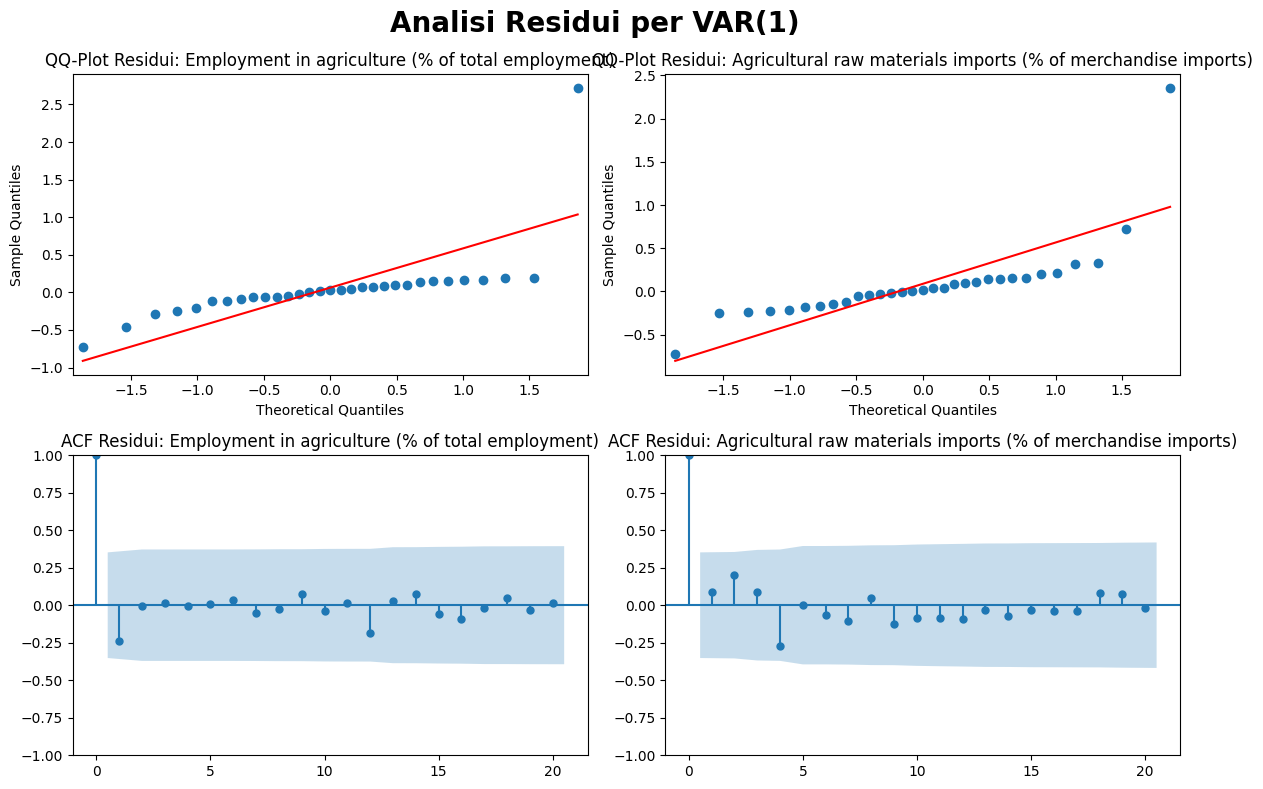



ANALISI COPPIA: 'Employment in agriculture (% of total employment)' -> 'Land under cereal production (hectares)'


Ottimizzazione AIC:  20%|██        | 2/10 [00:06<00:25,  3.17s/it]


Ritardo ottimale (AIC) scelto (p): 2
Ljung-Box p-value (Employment in agriculture (% of total employment)): 0.8205
Ljung-Box p-value (Land under cereal production (hectares)): 0.3300


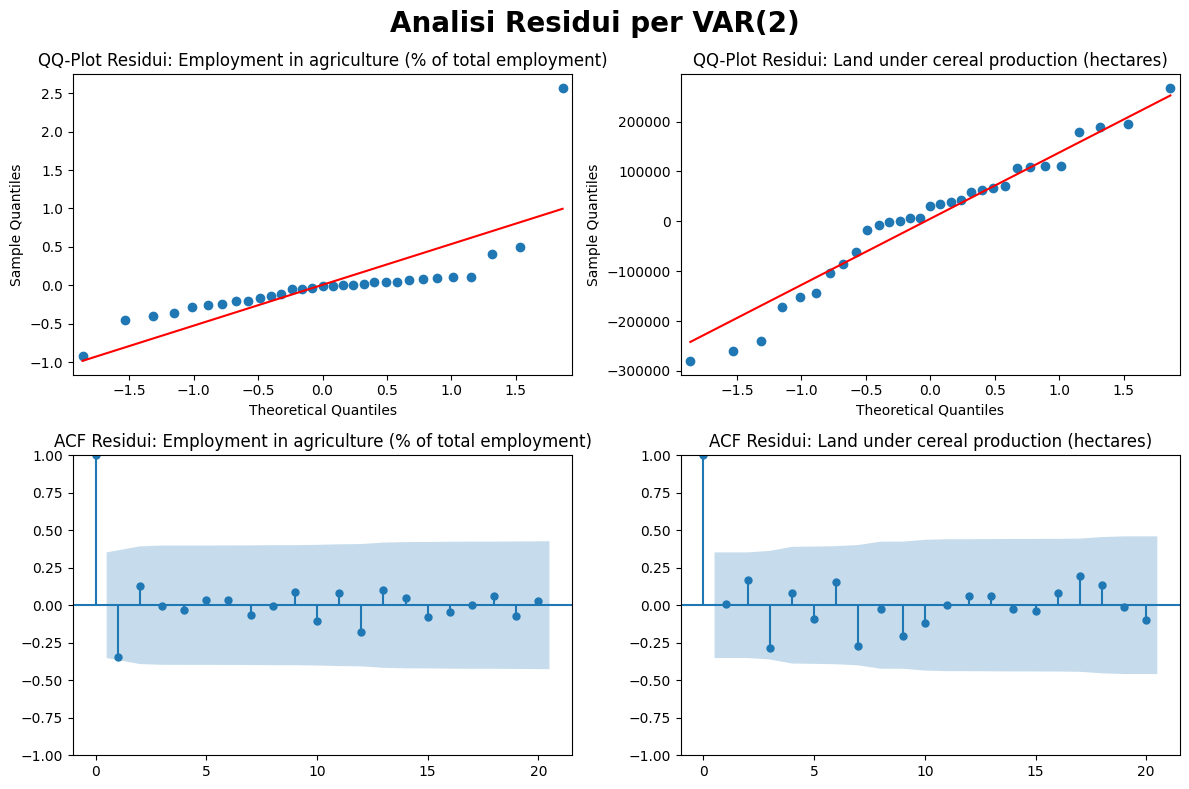



ANALISI COPPIA: 'Land under cereal production (hectares)' -> 'Fertilizer consumption (kilograms per hectare of arable land)'


Ottimizzazione AIC:  90%|█████████ | 9/10 [02:04<00:13, 13.84s/it]


Ritardo ottimale (AIC) scelto (p): 9
Ljung-Box p-value (Land under cereal production (hectares)): 0.2951
Ljung-Box p-value (Fertilizer consumption (kilograms per hectare of arable land)): 0.9840


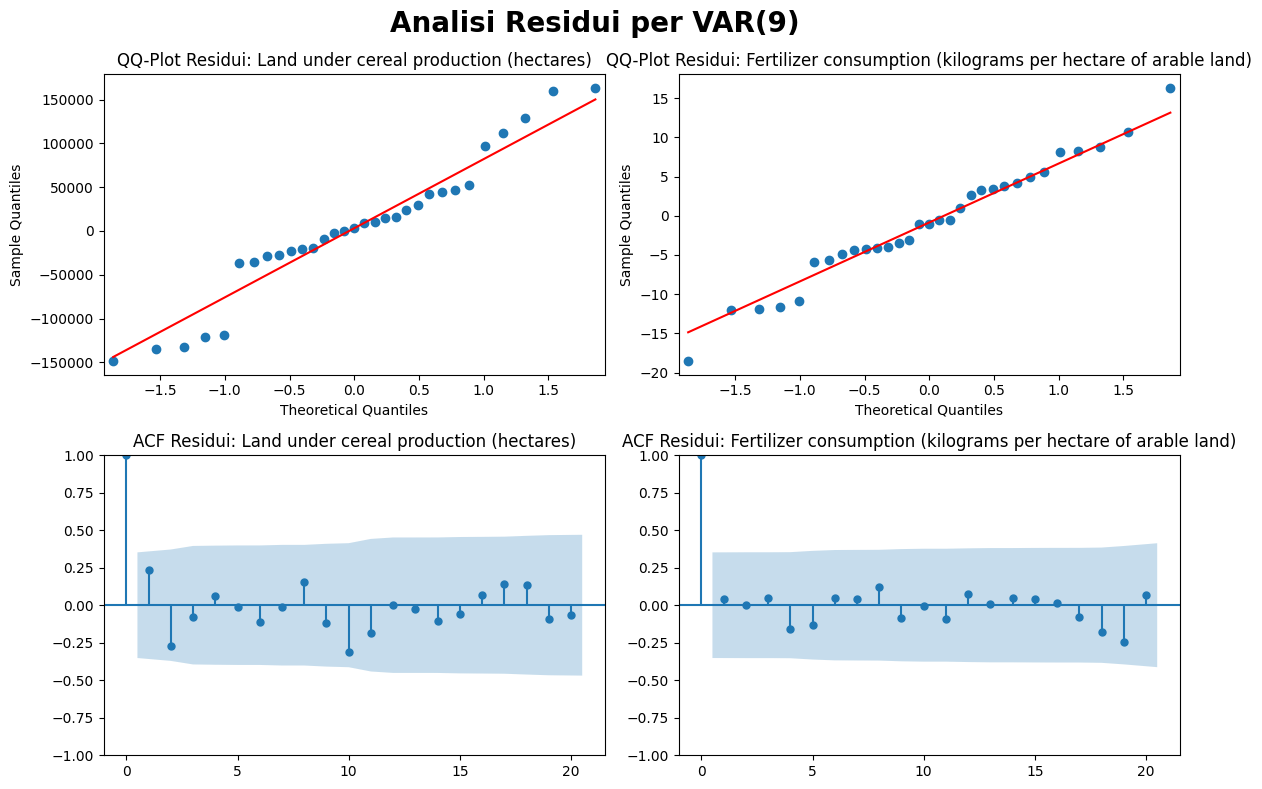

In [77]:
CAUSEEFFECT_COUPLES = [
    ['Employment in agriculture (% of total employment)', 'Agricultural raw materials imports (% of merchandise imports)'],
    ['Employment in agriculture (% of total employment)', 'Land under cereal production (hectares)'],
    ['Land under cereal production (hectares)', 'Fertilizer consumption (kilograms per hectare of arable land)']
]

_pairs = []
for item in CAUSEEFFECT_COUPLES:
    _pairs.append((item[0], item[1]))

summary_results = {}
for causing, caused in _pairs:
    print(f"ANALISI COPPIA: '{causing}' -> '{caused}'")
    df_pair = df_var_input[[causing, caused]].dropna()
    n_obs = df_pair.shape[0]

    safe_maxlags = min(10, n_obs // 2 - 1) 
    if safe_maxlags < 1:
        print(f"Pochi dati ({n_obs} osservazioni).")
        continue
    
    p_selected = optimize_VARMAX(df_pair, safe_maxlags)
    print(f"Ritardo ottimale (AIC) scelto (p): {p_selected}")
    fitted_model = VARMAX(df_pair, order=(p_selected, 0)).fit(disp=False)
    # print(fitted_model.summary())
    
    resid = fitted_model.resid
    
    ljung_pvals = {}
    for col in resid.columns:
        lb_df = acorr_ljungbox(resid[col].dropna(), lags=[10], return_df=True)
        pval = lb_df['lb_pvalue'].iloc[0]
        ljung_pvals[col] = pval
        print(f"Ljung-Box p-value ({col}): {pval:.4f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Analisi Residui per VAR({p_selected})", fontsize=20, fontweight='bold')

    qqplot(resid[causing].dropna(), line='s', ax=axes[0, 0])
    axes[0, 0].set_title(f"QQ-Plot Residui: {causing}")
    qqplot(resid[caused].dropna(), line='s', ax=axes[0, 1])
    axes[0, 1].set_title(f"QQ-Plot Residui: {caused}")

    plot_acf(resid[causing].dropna(), ax=axes[1, 0], lags=20)
    axes[1, 0].set_title(f"ACF Residui: {causing}")
    plot_acf(resid[caused].dropna(), ax=axes[1, 1], lags=20)
    axes[1, 1].set_title(f"ACF Residui: {caused}")
    
    plt.tight_layout()
    plt.show()
    
    summary_results[(causing, caused)] = {
        "p_selected": p_selected,
        "n_obs": n_obs,
        "ljungbox_pvals": ljung_pvals,
        "fitted_model": fitted_model
    }
    print('\n')

In [97]:
def rolling_forecast(df, causing, caused, p, train_len, horizon, window, method) -> list:
    total_len = train_len + horizon
    pair_vars = [causing, caused]

    if method == 'last':
        causing_pred_last = []
        caused_pred_last = []
        for i in range(train_len, total_len, window):
            causing_last = df[:i].iloc[-1][causing]
            caused_last = df[:i].iloc[-1][caused]
            causing_pred_last.extend(causing_last for _ in range(window))
            caused_pred_last.extend(caused_last for _ in range(window))
        return causing_pred_last, caused_pred_last
    
    elif method == 'VAR':
        causing_pred_VAR = []
        caused_pred_VAR = []
        for i in range(train_len, total_len, window):
            try:
                model_data = df[pair_vars][:i]
                model = VARMAX(model_data, order=(p,0))
                res = model.fit(disp=False)
                predictions = res.forecast(steps=window)
                oos_pred_causing = predictions[causing]
                oos_pred_caused = predictions[caused]
                causing_pred_VAR.extend(oos_pred_causing)
                caused_pred_VAR.extend(oos_pred_caused)
            except Exception as e:
                print(f"Errore stima a i={i}: {e}. Inserimento NaN.")
                causing_pred_VAR.extend(np.nan for _ in range(window))
                caused_pred_VAR.extend(np.nan for _ in range(window))
        return causing_pred_VAR, caused_pred_VAR

In [ ]:
# def show_comparison_plot():
#     fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))
#     fig.suptitle(f"Comparison on forecasting methods for {target}", fontsize=16, fontweight="bold")

#     ax1.plot(train_data['Year'], train_data[target], label='Train')
#     ax1.plot(test_data['Year'], test_data['Value'], color=colors[0], linestyle='-', label='Actual')
#     ax1.plot(test_data['Year'], test_data['pred_last_value'], color=colors[2], linestyle='-.', label='Last Value')
#     ax1.plot(test_data['Year'], test_data['pred_ARIMAX'], color=colors[3], linestyle='--', label=f'ARIMAX{order}')
#     ax1.legend(loc='best')
#     ax1.set_title("Full time series")
#     ax1.set_xlabel('Year')
#     ax1.set_ylabel('Value')
#     ax1.grid(True, alpha=0.3)
#     start_year = int(test_data['Year'].iloc[0])
#     end_year = int(test_data['Year'].iloc[-1])
#     ax1.axvspan(start_year - 0.5, end_year + 0.5, color='#808080', alpha=0.2, label='Test Set')

#     ax2.plot(test_data['Year'], test_data['Value'], color=colors[0], linestyle='-', label='Actual', marker="o")
#     ax2.plot(test_data['Year'], test_data['pred_last_value'], color=colors[2], linestyle='-.', label='Last Value', marker="^")
#     ax2.plot(test_data['Year'], test_data['pred_ARIMAX'], color=colors[3], linestyle='--', label=f'ARIMAX{order}', marker="d")
#     ax2.legend(loc='best')
#     ax2.set_title("Zoom on test set")
#     ax2.set_xlabel('Year')
#     ax2.grid(True, alpha=0.3)

#     ax1.tick_params(labelbottom=True)
#     ax2.tick_params(labelbottom=True)
#     plt.setp(ax2.get_xticklabels(), visible=True)
#     plt.tight_layout() 
#     plt.show()
    
# def calculate_plot_mae_mse():
#     mae_last = mean_absolute_error(test_data['Value'], test_data['pred_last_value'])
#     mae_arimax = mean_absolute_error(test_data['Value'], test_data['pred_ARIMAX'])

#     mse_last = mean_squared_error(test_data['Value'], test_data['pred_last_value'])
#     mse_arimax = mean_squared_error(test_data['Value'], test_data['pred_ARIMAX'])

#     print(f"Metriche di errore per {target}:")
#     print(f"  MAE -> Last Value: {mae_last:.5f}, ARIMAX{order}: {mae_arimax:.5f}")
#     print(f"  MSE -> Last Value: {mse_last:.5f}, ARIMAX{order}: {mse_arimax:.5f}")

#     results_metrics = pd.DataFrame({
#         'Method': ['Last Value', f'ARIMAX{order}'],
#         'MSE': [mse_last, mse_arimax],
#         'MAE': [mae_last, mae_arimax]
#     })

#     fig, ax = plt.subplots(figsize=(8, 5))
#     x = np.arange(len(results_metrics['Method']))
#     width = 0.35

#     bar1 = ax.bar(x - width/2, results_metrics['MSE'], width, label='MSE')
#     bar2 = ax.bar(x + width/2, results_metrics['MAE'], width, label='MAE')

#     ax.set_xticks(x)
#     ax.set_xticklabels(results_metrics['Method'])
#     ax.set_title(f"Error on predictions for {target}")
#     ax.set_ylabel("Error Value")
#     ax.legend()
#     ax.grid(alpha=0.3, axis='y')

#     def add_labels(bars):
#         for bar in bars:
#             height = bar.get_height()
#             ax.annotate(f'{height:.5f}',
#                         xy=(bar.get_x() + bar.get_width() / 2, height),
#                         xytext=(0, 3),
#                         textcoords="offset points",
#                         ha='center', va='bottom', fontsize=9)

#     add_labels(bar1)
#     add_labels(bar2)

In [98]:
TRAIN_LEN = int(len(df_var_input) * 0.8)
HORIZON = len(df_var_input) - TRAIN_LEN
WINDOW = 1

forecast_results = {}
test_set_diff = df_var_input.iloc[TRAIN_LEN : TRAIN_LEN + HORIZON]

for pair_key, results in summary_results.items():
    causing, caused = pair_key
    pair_vars = [causing, caused]
    optimal_p = results['p_selected']
    print(pair_key)
    causing_pred_last, caused_pred_last = rolling_forecast(df_var_input, causing, caused, optimal_p, TRAIN_LEN, HORIZON, WINDOW, 'last')
    causing_pred_VAR, caused_pred_VAR = rolling_forecast(df_var_input, causing, caused, optimal_p, TRAIN_LEN, HORIZON, WINDOW, 'VAR')
    
    df_test_pair = pd.DataFrame({
        f"{causing}_actual": test_set_diff[causing],
        f"{caused}_actual": test_set_diff[caused],
        f"{causing}_pred_last": causing_pred_last,
        f"{caused}_pred_last": caused_pred_last,
        f"{causing}_pred_VAR": causing_pred_VAR,
        f"{caused}_pred_VAR": caused_pred_VAR,
    }, index=test_set_diff.index)
    
    forecast_results[pair_key] = df_test_pair

display(forecast_results)
    # # DataFrame per salvare i risultati finali (in LIVELLO)
    # test_df_livello = wide_df[pair_vars].iloc[TRAIN_LEN : TRAIN_LEN + HORIZON].copy()
    # test_df_livello = test_df_livello.rename(columns={causing: f"{causing}_actual", 
    #                                                 caused: f"{caused}_actual"})
    
    # for var in pair_vars:
    #     last_known_level = wide_df[var].iloc[TRAIN_LEN - 1]
    #     preds_diff = forecast_df_diff[var].values # .values per evitare problemi di indice
    #     preds_level = last_known_level + np.cumsum(preds_diff)
    #     test_df_livello[f"{var}_pred"] = preds_level

    # forecast_results[pair_key] = test_df_livello
    
    # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # test_df_livello[[f"{causing}_actual", f"{causing}_pred"]].plot(ax=axes[0], title=causing)
    # axes[0].legend()
    
    # # Grafico per 'caused'
    # test_df_livello[[f"{caused}_actual", f"{caused}_pred"]].plot(ax=axes[1], title=caused)
    # axes[1].legend()
    
    # plt.tight_layout()
    # plt.show()
    
    # # Calcola l'errore (RMSE)
    # try:
    #     rmse_causing = np.sqrt(mean_squared_error(test_df_livello[f"{causing}_actual"], test_df_livello[f"{causing}_pred"]))
    #     rmse_caused = np.sqrt(mean_squared_error(test_df_livello[f"{caused}_actual"], test_df_livello[f"{caused}_pred"]))
    #     print(f"RMSE (Root Mean Squared Error) per {causing}: {rmse_causing:.4f}")
    #     print(f"RMSE (Root Mean Squared Error) per {caused}: {rmse_caused:.4f}")
    # except ValueError as e:
    #     print(f"Errore nel calcolo RMSE (possibili NaN): {e}")

('Employment in agriculture (% of total employment)', 'Agricultural raw materials imports (% of merchandise imports)')
('Employment in agriculture (% of total employment)', 'Land under cereal production (hectares)')
('Land under cereal production (hectares)', 'Fertilizer consumption (kilograms per hectare of arable land)')
Errore stima a i=24: Matrix is not positive definite. Inserimento NaN.
Errore stima a i=25: Matrix is not positive definite. Inserimento NaN.
Errore stima a i=26: Matrix is not positive definite. Inserimento NaN.
Errore stima a i=27: array must not contain infs or NaNs. Inserimento NaN.
Errore stima a i=28: Matrix is not positive definite. Inserimento NaN.
Errore stima a i=30: Schur decomposition solver error.. Inserimento NaN.


{('Employment in agriculture (% of total employment)',
  'Agricultural raw materials imports (% of merchandise imports)'):       Employment in agriculture (% of total employment)_actual  \
 Year                                                             
 2016                                           3.884447          
 2017                                           3.782819          
 2018                                           3.756879          
 2019                                           3.889869          
 2020                                           3.981957          
 2021                                           4.050170          
 2022                                           3.787698          
 
       Agricultural raw materials imports (% of merchandise imports)_actual  \
 Year                                                                         
 2016                                           2.231932                      
 2017                               

In [100]:
# --- CODICE DI DEBUG ---

# 1. Definisci la coppia che ha causato il primo errore
pair_key = ('Land under cereal production (hectares)', 'Fertilizer consumption (kilograms per hectare of arable land)')
causing, caused = pair_key
pair_vars = [causing, caused]

# 2. Definisci il TRAIN_LEN che ha causato l'errore
# (Il tuo loop inizia a TRAIN_LEN, e il primo errore è a i=24)
TRAIN_LEN = 24 

# 3. Isola il DataFrame esatto che causa il crash
df_problem = df_var_input[pair_vars]

print(f"--- Ispezione del DataFrame problematico (prime {TRAIN_LEN} righe) ---")
display(df_problem)

print("\n--- Controllo 1: Ci sono NaN? ---")
print(df_problem.isnull().sum())

print("\n--- Controllo 2: Ci sono Varianze Zero? (Guarda 'std') ---")
display(df_problem.describe())

--- Ispezione del DataFrame problematico (prime 24 righe) ---


,Land under cereal production (hectares),Fertilizer consumption (kilograms per hectare of arable land)
Year,,
1992,-176287.0,-11.035499
1993,-149640.0,6.587672
1994,27970.0,1.482552
1995,112500.0,-11.717296
1996,7398.0,11.080728
1997,-28615.0,-14.689567
1998,-112695.0,7.678046
1999,91611.0,2.052248
2000,-36757.0,-3.415622



--- Controllo 1: Ci sono NaN? ---
Land under cereal production (hectares)                          0
Fertilizer consumption (kilograms per hectare of arable land)    0
dtype: int64

--- Controllo 2: Ci sono Varianze Zero? (Guarda 'std') ---


,Land under cereal production (hectares),Fertilizer consumption (kilograms per hectare of arable land)
count,31.000000,31.000000
mean,-44874.322581,-0.204769
std,139919.249990,18.590524
min,-556947.000000,-59.952059
25%,-113050.500000,-10.612334
50%,-33340.000000,1.560847
75%,30100.000000,9.622242
max,150352.000000,38.201418
